## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2024-11-28 08:48:23--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9 [following]
--2024-11-28 08:48:23--  https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc894e726d5240253db984363800.dl.dropboxusercontent.com/cd/0/inline/CfOaHzbTS9X5NjRp3gwgodSYVHYtLAtG0JnhhaIyn5ZKGVoResh98622dvgSUnX6-FMsxvUDuM2PK-jGKV7QAh_GV3FD4jYznZiBGLP-kOUa-bcFe1L9Nr-WWaxiahYyeWc/file# [following]
--2024-11-28 08:48:24--  https://uc894e726d5240253db984363800.dl.dropboxusercontent.com/cd/0/inline/CfOaHzbTS9

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [4]:
import pandas as pd
import numpy as np
file_name="/mnt/c/Users/macas/Desktop/High level programming/data_000637.txt"

#1
data=pd.read_csv(file_name)
num_rows=data.shape
print(num_rows)
#N have to be larger than 10k and smaller of 1310720
N=60000

#2
data['ORBIT_CNT_diff'] = data['ORBIT_CNT'].diff()  # Difference ORBIT_CNT
data['BX_COUNTER_diff'] = data['BX_COUNTER'].diff().abs()  # Positive differences BX_COUNTER
# Filtrar solo las filas donde ORBIT_CNT ha cambiado (es decir, ha incrementado)
orbit_changes = data[data['ORBIT_CNT_diff'] != 0]
bx_per_orbit = orbit_changes['BX_COUNTER_diff'].mean()
print(f"The number of BX in a ORBIT is: {bx_per_orbit}\n")


#3
total_bx=data['BX_COUNTER'].sum()
total_time=total_bx*0.025  
total_time_sec=total_time/ 1e6
print(f"Data time: {total_time_sec:.2f} seconds\n")

#4
#defining a new column
data['ABSOLUTE_TIME']=(data['ORBIT_CNT']*bx_per_orbit*25) + (data['BX_COUNTER']*25) + (data['TDC_MEAS']*25)
#verify data
print(data[['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS', 'ABSOLUTE_TIME']].head(),'\n')

#5
data['HEAD'] = np.random.randint(0, 2, len(data))
print(data['HEAD'])

#6 New Df with only row's HEAD=1
new_data = data[data['HEAD'] == 1]
print('\n', new_data)

(1310720, 6)
The number of BX in a ORBIT is: 3035.5425971180584

Data time: 58.36 seconds

    ORBIT_CNT  BX_COUNTER  TDC_MEAS  ABSOLUTE_TIME
0  3869200167        2374        26   2.936280e+14
1  3869200167        2374        27   2.936280e+14
2  3869200167        2553        28   2.936280e+14
3  3869200167        2558        19   2.936280e+14
4  3869200167        2760        25   2.936280e+14 

0          0
1          1
2          1
3          1
4          1
          ..
1310715    0
1310716    1
1310717    0
1310718    1
1310719    0
Name: HEAD, Length: 1310720, dtype: int64

          HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
5           1     0           63  3869200167        2762        

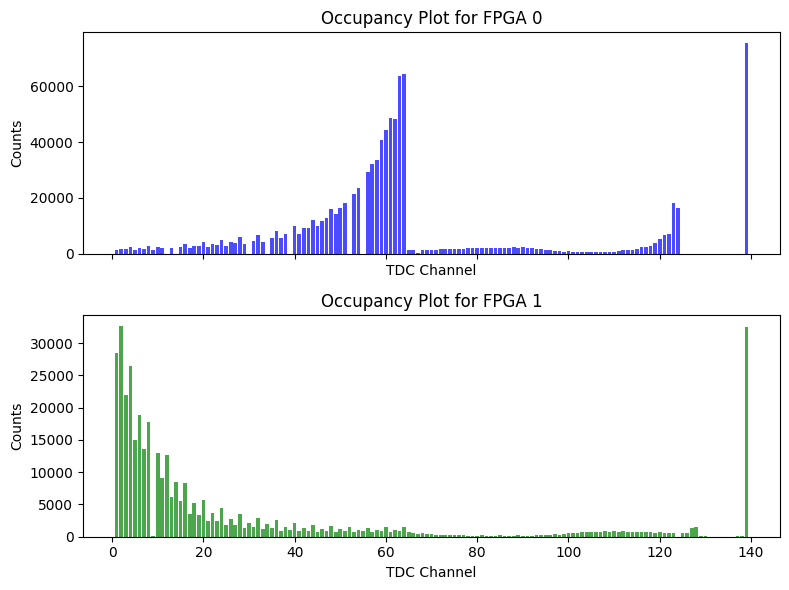

In [11]:
#7 Two occupancy plots
import matplotlib.pyplot as plt

# Filtrar datos por cada FPGA
fpga_0_data = data[data['FPGA'] == 0]
fpga_1_data = data[data['FPGA'] == 1]

# Count ocurrencies for each channel TDC for each FPGA 
fpga_0_counts = fpga_0_data['TDC_CHANNEL'].value_counts()
fpga_1_counts = fpga_1_data['TDC_CHANNEL'].value_counts()

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# FPGA 0
axes[0].bar(fpga_0_counts.index, fpga_0_counts.values, color='blue', alpha=0.7)
axes[0].set_title('Occupancy Plot for FPGA 0')
axes[0].set_xlabel('TDC Channel')
axes[0].set_ylabel('Counts')

# FPGA 1
axes[1].bar(fpga_1_counts.index, fpga_1_counts.values, color='green', alpha=0.7)
axes[1].set_title('Occupancy Plot for FPGA 1')
axes[1].set_xlabel('TDC Channel')
axes[1].set_ylabel('Counts')

plt.tight_layout()
plt.show()


In [12]:
#8 Find out the noisy channels
channel_counts = data.groupby('TDC_CHANNEL').size()
top_nchannels = channel_counts.sort_values(ascending=False).head(3)
print(top_nchannels)


TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64


In [13]:
#9 total unique orbits and TDC =139
total_uorbits = data['ORBIT_CNT'].nunique()
filtered_data = data[data['TDC_CHANNEL'] == 139]

uorbits_139 = filtered_data['ORBIT_CNT'].nunique()
print(f"Total unique orbits: {total_uorbits}")
print(f"Unique orbits with at least one measurement from TDC_CHANNEL=139: {uorbits_139}")


Total unique orbits: 11001
Unique orbits with at least one measurement from TDC_CHANNEL=139: 10976
